## `Part I.Set up`

Main library for model building Tensorflow <br>
Libraries for sound reading and procesing `sounddevice` <br>
Please install the packages required by running the `requirement_installation file`

In [1]:
import os
import pathlib
import random

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

import sounddevice as sd
import soundfile as sf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

### Import the mini Speech Commands dataset

To save time with data loading, we use a mini-version of the Speech Commands dataset with 8 classes only. <br >The [original dataset](https://www.tensorflow.org/datasets/catalog/speech_commands) consists of over 105,000 audio files in the [WAV (Waveform) audio file format](https://www.aelius.com/njh/wavemetatools/doc/riffmci.pdf) of people saying 35 different words. This data was collected by Google and released under a CC BY license.

Download and extract the `mini_speech_commands.zip` file containing the smaller Speech Commands datasets with `tf.keras.utils.get_file`:

The dataset's audio clips are stored in eight folders corresponding to each speech command: `no`, `yes`, `down`, `go`, `left`, `up`, `right`, and `stop`:

Files were divided into different folders for easy labelling and loading using  `keras.utils.audio_dataset_from_directory`.

In [2]:
DATASET_PATH = './mini_speech_commands'

data_dir = pathlib.Path(DATASET_PATH)

In [3]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[(commands != 'README.md') & (commands != '.DS_Store')]
print('Commands:', commands)

Commands: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


## `Part II. Data exploration`

#### Define a function to read the sound files

In [4]:
def read_sound(path):
    data, samplerate = sf.read(path)
    N = data.size
    time_array = np.arange(N)/samplerate

    return data, samplerate, time_array

### Random, read and draw amplitude plot of one file from each label 
#### The amplitude plot does not seem to give important information

Label sound: down


Label sound: go


Label sound: left


Label sound: no


Label sound: right


Label sound: stop


Label sound: up


Label sound: yes


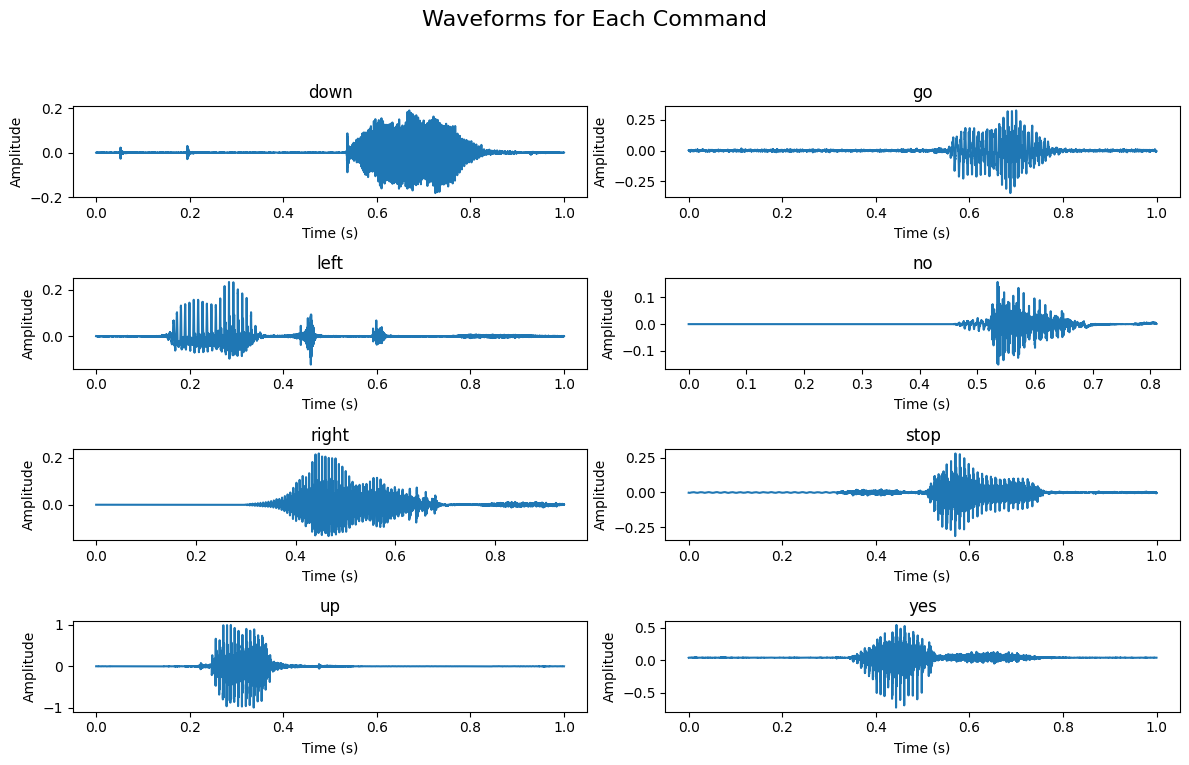

In [5]:
fig, axs = plt.subplots(4, 2, figsize=(12, 8))
fig.suptitle('Waveforms for Each Command', fontsize=16)

# Loop through each command and plot a random audio waveform in a subplot
for i, command in enumerate(commands):
    # Get the list of audio files in the command folder
    command_folder = os.path.join(data_dir, command)
    file_list = tf.io.gfile.listdir(command_folder)

    # Randomly select an audio file from the list
    random_file = random.choice(file_list)
    random_file_path = os.path.join(command_folder, random_file)

    # Read the audio file using the read_sound function
    data, samplerate, time_array = read_sound(random_file_path)
    print('Label sound:', command)
    display.display(display.Audio(data, rate=16000))
    # Plot the waveform in the current subplot
    axs[i // 2, i % 2].plot(time_array, data)
    axs[i // 2, i % 2].set_title(command)
    axs[i // 2, i % 2].set_xlabel('Time (s)')
    axs[i // 2, i % 2].set_ylabel('Amplitude')
    
# Adjust layout for better spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])

# Show the subplots
plt.show()

### Display the sound to hear

## `Part 3. Spectrogram analysis`

### A custom spectrogram method for plotting a spectrogram for each random file 

Random a file for plotting

In [6]:
samplerate_1 = 0
while samplerate_1 != 16000:
    command_1 = commands[np.random.randint(len(commands))]
    command_folder = os.path.join(data_dir, command)
    file_list = tf.io.gfile.listdir(command_folder)

        # Randomly select an audio file from the list
    random_file_1 = random.choice(file_list)
    random_file_path_1 = os.path.join(command_folder, random_file_1)

        # Read the audio file using the read_sound function
    data_1, samplerate_1, time_array_1 = read_sound(random_file_path_1)


In [7]:
print("Shape of example sound data", data_1.shape)
print("Sample rate of the example sound data", samplerate_1)

Shape of example sound data (16000,)
Sample rate of the example sound data 16000


The brain's response time people (BRT) is about 0.1s. Here we calculate the number of window of the spectrogram based on this value

In [8]:
BRT = 100*10**-3
Nw = samplerate_1*BRT
power_2 = np.ceil(np.log2(Nw))
Nw = 2**power_2
Nw


2048.0

Apply a Hamming window for each window

In [9]:
Nw_window = np.hamming(Nw)

In [10]:
N = len(data_1)
Nsp = int((N - Nw) / (Nw/4)) + 1

spectrogram_matrix = np.zeros((int(Nw), Nsp))
print(spectrogram_matrix.shape)

(2048, 28)


### Calculate the spectro gram matrix using custom method

In [11]:
for i in range(Nsp):
    window_start = int(i) * int((int(Nw)/4))
    window_end = window_start + int(Nw)
    window_data = data[window_start:window_end]
    
    # Compute FFT and store in the matrix
    fft_result = np.fft.fft(Nw_window*window_data, int(Nw))
    spectrogram_matrix[:, i] = abs(fft_result)

In [12]:
signal_size = data_1.size
sampling_rate = samplerate_1

freq = np.arange(signal_size) / signal_size * sampling_rate

In [13]:
freqs = np.arange(Nw)*freq[-1]/Nw
times = np.arange(Nsp)*Nw/4/freq[-1]

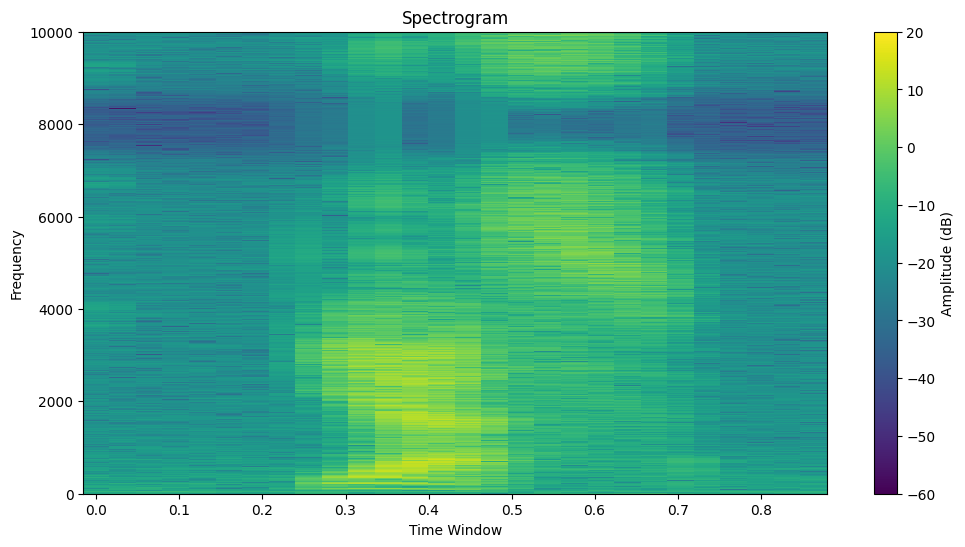

In [14]:
spectrogram_dB = 10 * np.log10(spectrogram_matrix + 1e-9)

plt.figure(figsize=(12, 6))
cax = plt.pcolor(times,freqs, spectrogram_dB, vmin=-60, vmax=20)
plt.colorbar(cax, label='Amplitude (dB)')
plt.xlabel('Time Window')
plt.ylim(0, 10000)
plt.ylabel('Frequency')
plt.title('Spectrogram')
plt.show()

### Since the custom method is not optimized for the tensorflow library, we will use a function that is wisely used in audioprocessing which is tf.signal.stft (Short Fourier Transform)
The waveforms in the dataset are represented in the time domain. The function will transform the waveforms from the time-domain signals into the time-frequency-domain signals by computing the [short-time Fourier transform (STFT)](https://en.wikipedia.org/wiki/Short-time_Fourier_transform) to convert the waveforms to as [spectrograms](https://en.wikipedia.org/wiki/Spectrogram), which show frequency changes over time and can be represented as 2D images. You will feed the spectrogram images into your neural network to train the model.

A Fourier transform (`tf.signal.fft`) converts a signal to its component frequencies, but loses all time information. In comparison, STFT (`tf.signal.stft`) splits the signal into windows of time and runs a Fourier transform on each window, preserving some time information, and returning a 2D tensor that you can run standard convolutions on.

Create a utility function for converting waveforms to spectrograms:

- The waveforms need to be of the same length, so that when you convert them to spectrograms, the results have similar dimensions. This can be done by simply zero-padding the audio clips that are shorter than one second (using `tf.zeros`).
- When calling `tf.signal.stft`, choose the `frame_length` and `frame_step` parameters such that the generated spectrogram "image" is almost square. For more information on the STFT parameters choice, refer to [this Coursera video](https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) on audio signal processing and STFT.
- The STFT produces an array of complex numbers representing magnitude and phase. However, in this tutorial you'll only use the magnitude, which you can derive by applying `tf.abs` on the output of `tf.signal.stft`.
#### Define 3 spectrogram processing method 
`using the spectrogram function only` <br> `log scale preprocessing` <br> ` normalized_mel_spectrogram`



### Preprocessing choice = 0,1,2 will be the choice of spectrogram base function, spectrogram log scale, normalized_mel_spectrogram respectively

In [15]:
preproceesing_choice = 2

In [16]:
def spectrogram_fn(input_signal, nfft, window, stride, name=None):
    """
    Create spectrogram from audio.
    Args:
      input_signal: An 1-D audio signal Tensor.
      nfft: Size of FFT.
      window: Size of window.
      stride: Size of hops between windows.
      name: A name for the operation (optional).
    Returns:
      A tensor of spectrogram.
    """

    # TODO: Support audio with channel > 1.
    # Compute the short-time Fourier transform (STFT) of the input signal
    return tf.math.abs(
        tf.signal.stft(
            input_signal,
            frame_length=window,
            frame_step=stride,
            fft_length=nfft,
            window_fn=tf.signal.hann_window,
            pad_end=True,)
            )


def spectrogram_base(x, sr=16000, n_mel_bins=80):
    spec_stride = 128
    spec_len = 1024

    spectrogram = spectrogram_fn(
        x, nfft=spec_len, window=spec_len, stride=spec_stride
    )


    return spectrogram

def spectrogram_log(x, sr=16000, n_mel_bins=80):
    spec_stride = 128
    spec_len = 1024

    spectrogram = spectrogram_fn(
        x, nfft=spec_len, window=spec_len, stride=spec_stride
    )
    spectrogram = tf.math.log(spectrogram + 1e-9)
    
    return spectrogram

def normalized_mel_spectrogram(x, sr=16000, n_mel_bins=80):
    spec_stride = 128
    spec_len = 1024

    spectrogram = spectrogram_fn(
        x, nfft=spec_len, window=spec_len, stride=spec_stride
    )

    num_spectrogram_bins = spec_len // 2 + 1  # spectrogram.shape[-1]
    lower_edge_hertz, upper_edge_hertz = 40.0, 8000.0
    num_mel_bins = n_mel_bins
    linear_to_mel_weight_matrix = tf.signal.linear_to_mel_weight_matrix(
      num_mel_bins, num_spectrogram_bins, sr, lower_edge_hertz,
      upper_edge_hertz)
    mel_spectrograms = tf.tensordot(spectrogram, linear_to_mel_weight_matrix, 1)
    mel_spectrograms.set_shape(spectrogram.shape[:-1].concatenate(linear_to_mel_weight_matrix.shape[-1:]))

    # Compute a stabilized log to get log-magnitude mel-scale spectrograms.
    log_mel_spectrograms = tf.math.log(mel_spectrograms + 1e-6)
    avg = tf.math.reduce_mean(log_mel_spectrograms)
    std = tf.math.reduce_std(log_mel_spectrograms)

    return (log_mel_spectrograms - avg) / std

### Based on the preprocessing choice, choose the spectrogram function and add axis to the spectrogram for the requirement of tensor 3D input 

In [17]:
def get_spectrogram(waveform):
  if preproceesing_choice == 0:
    spectrogram = spectrogram_base(waveform)
  elif preproceesing_choice == 1:
    spectrogram = spectrogram_log(waveform)
  else: 
    spectrogram = normalized_mel_spectrogram(waveform)

  spectrogram = spectrogram[..., tf.newaxis] #Add new axis for the spectrogram to feed in the model
  return spectrogram

Next, start exploring the data. Print the shapes of one example's tensorized waveform and the corresponding spectrogram, and play the original audio:

Since the folders are ready, we use
 `keras.utils.audio_dataset_from_directory`.

The audio clips are 1 second or less at 16kHz. The `output_sequence_length=16000` pads the short ones to exactly 1 second (and would trim longer ones) so that they can be easily batched.

In [18]:
train_ds, val_ds = tf.keras.utils.audio_dataset_from_directory(
    directory=data_dir,
    batch_size=64,                #The number of audio samples to include in each batch
    validation_split=0.2,         #define the ratio between validation files and total files 
    seed=0,
    output_sequence_length=16000, #define the length of one sound file
    subset='both')

label_names = np.array(train_ds.class_names)
print()
print("label names:", label_names)

Found 8000 files belonging to 8 classes.
Using 6400 files for training.
Using 1600 files for validation.

label names: ['down' 'go' 'left' 'no' 'right' 'stop' 'up' 'yes']


The dataset now contains batches of audio clips and integer labels. The audio clips have a shape of `(batch, samples, channels)`.

In [19]:
train_ds.element_spec

(TensorSpec(shape=(None, 16000, None), dtype=tf.float32, name=None),
 TensorSpec(shape=(None,), dtype=tf.int32, name=None))

This dataset only contains single channel audio, so use the `tf.squeeze` function to drop the extra axis:

In [20]:
def squeeze(audio, labels):
  audio = tf.squeeze(audio, axis=-1)
  return audio, labels

train_ds = train_ds.map(squeeze, tf.data.AUTOTUNE)
val_ds = val_ds.map(squeeze, tf.data.AUTOTUNE)

The `utils.audio_dataset_from_directory` function only returns up to two splits. It's a good idea to keep a test set separate from your validation set.
Ideally you'd keep it in a separate directory, but in this case you can use `Dataset.shard` to split the validation set into two halves. Note that iterating over **any** shard will load **all** the data, and only keep its fraction.

In [21]:
test_ds = val_ds.shard(num_shards=2, index=0)
val_ds = val_ds.shard(num_shards=2, index=1)

In [22]:
for example_audio, example_labels in train_ds.take(1):
  print(example_audio.shape)
  print(example_labels.shape)

(64, 16000)
(64,)


Now, define a function for displaying a spectrogram:

In [23]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = spectrogram.T
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

Plot the example's waveform over time and the corresponding spectrogram (frequencies over time):

In [24]:
for i in range(10):
  label = label_names[example_labels[i]]
  waveform = example_audio[i]
  spectrogram = get_spectrogram(waveform)

  print('Label:', label)
  print('Waveform shape:', waveform.shape)
  print('Spectrogram shape:', spectrogram.shape)
  print('Audio playback')
  display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (16000,)
Spectrogram shape: (125, 80, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (125, 80, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (125, 80, 1)
Audio playback


Label: go
Waveform shape: (16000,)
Spectrogram shape: (125, 80, 1)
Audio playback


Label: yes
Waveform shape: (16000,)
Spectrogram shape: (125, 80, 1)
Audio playback


Label: left
Waveform shape: (16000,)
Spectrogram shape: (125, 80, 1)
Audio playback


Label: right
Waveform shape: (16000,)
Spectrogram shape: (125, 80, 1)
Audio playback


Label: no
Waveform shape: (16000,)
Spectrogram shape: (125, 80, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (125, 80, 1)
Audio playback


Label: down
Waveform shape: (16000,)
Spectrogram shape: (125, 80, 1)
Audio playback


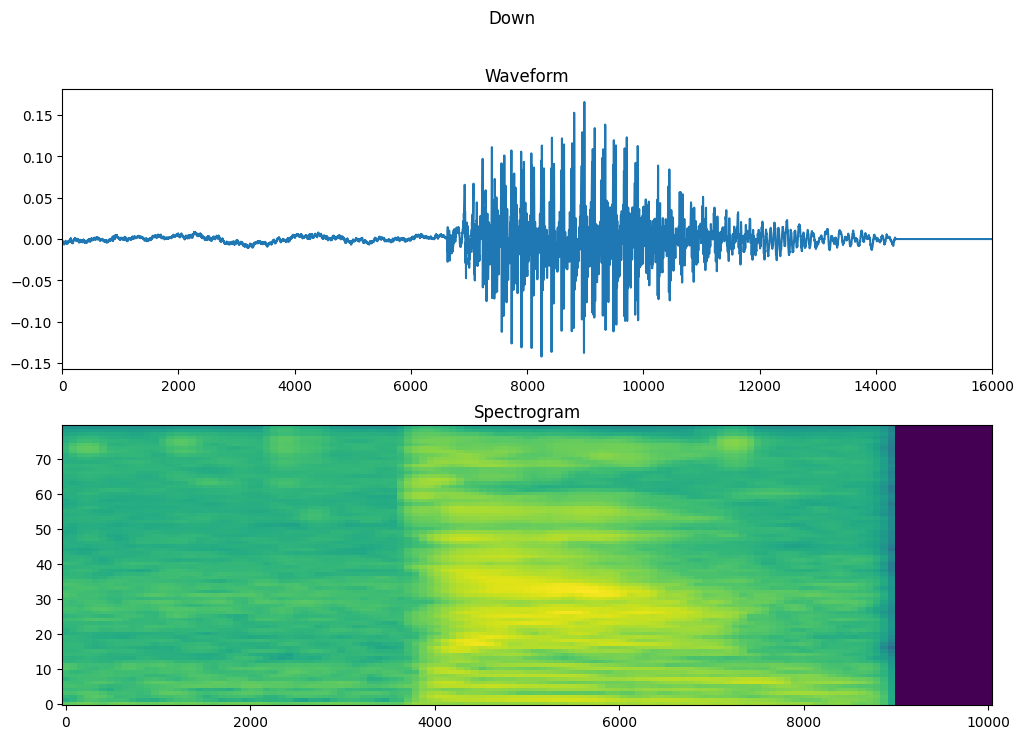

In [25]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Now, create spectrogramn datasets from the audio datasets:

In [26]:
def make_spec_ds(ds):
  return ds.map(
      map_func=lambda audio,label: (get_spectrogram(audio), label),
      num_parallel_calls=tf.data.AUTOTUNE)

In [27]:
train_spectrogram_ds = make_spec_ds(train_ds)
val_spectrogram_ds = make_spec_ds(val_ds)
test_spectrogram_ds = make_spec_ds(test_ds)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


Examine the spectrograms for different examples of the dataset:

In [28]:
for example_spectrograms, example_spect_labels in train_spectrogram_ds.take(1):
  break

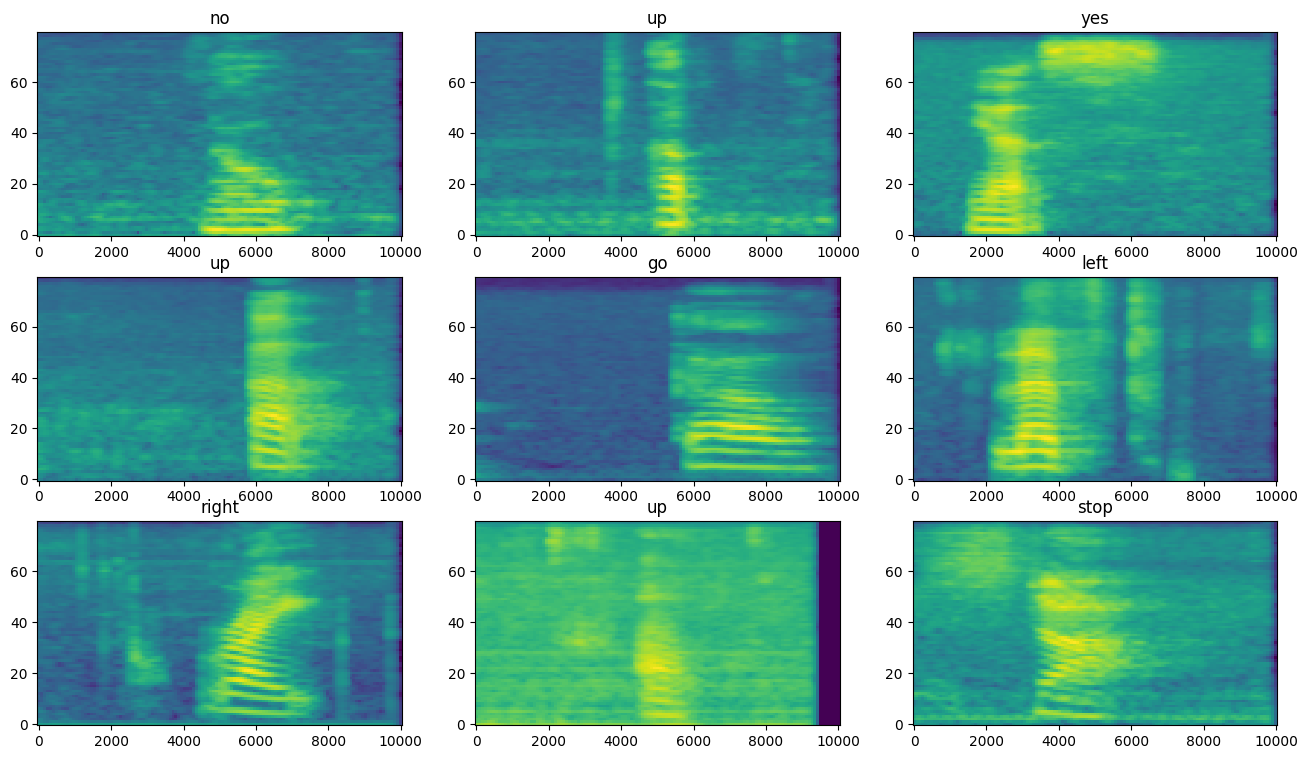

In [29]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(16, 9))

for i in range(n):
    r = i // cols
    c = i % cols
    ax = axes[r][c]
    plot_spectrogram(example_spectrograms[i].numpy(), ax)
    ax.set_title(label_names[example_spect_labels[i].numpy()])

plt.show()

## Part IV. Build and train the model

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [30]:
train_spectrogram_ds = train_spectrogram_ds.cache().shuffle(10000).prefetch(tf.data.AUTOTUNE)
val_spectrogram_ds = val_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)
test_spectrogram_ds = test_spectrogram_ds.cache().prefetch(tf.data.AUTOTUNE)

For the model, we use a simple convolutional neural network (CNN), since you have transformed the audio files into spectrogram images. Also, the attention mechanism also added for the model to dynamically focus on different parts of the input sequence during different frames.

Here we will use some preprocessing method between layers

- `Resizing`: to downsample the input to enable the model to train faster.
- `Normalization`: to normalize each pixel in the image based on its mean and standard deviation.

For the `Normalization` layer, its `adapt` method would first need to be called on the training data in order to compute aggregate statistics (that is, the mean and the standard deviation).

Explanation of the structure of the model is in the report


In [31]:
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras import layers, models

In [32]:
rnn_func = tf.keras.layers.LSTM
input_shape = example_spectrograms.shape[1:]
print('Input shape:', input_shape)
num_labels = len(label_names)

norm_layer = tf.keras.layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=train_spectrogram_ds.map(map_func=lambda spec, label: spec))

# Define the input layer
input_layer = tf.keras.layers.Input(shape=input_shape)

# Resize the input
resized_layer = tf.keras.layers.Resizing(32, 32)(input_layer)

# Normalize the input
normalized_layer = norm_layer(resized_layer)

# Convolutional layers
conv1_layer = tf.keras.layers.Conv2D(32, 3, activation='relu')(normalized_layer)
conv2_layer = tf.keras.layers.Conv2D(64, 3, activation='relu')(conv1_layer)
maxpool_layer = tf.keras.layers.MaxPooling2D()(conv2_layer)
dropout_layer = tf.keras.layers.Dropout(0.25)(maxpool_layer)

# Flatten the output
flatten_layer = tf.keras.layers.Flatten()(dropout_layer)

# Dense layers
dense1_layer = tf.keras.layers.Dense(128, activation='relu')(flatten_layer)
dropout2_layer = tf.keras.layers.Dropout(0.5)(dense1_layer)

# Reshape for LSTM
reshaped_layer = tf.keras.layers.Reshape((-1, 128))(dropout2_layer)

# LSTM layer
lstm_layer = rnn_func(64, return_sequences=True)(reshaped_layer)

# Attention Mechanism
permute1_layer = tf.keras.layers.Permute((2, 1))(lstm_layer)
dense_att_layer = tf.keras.layers.Dense(1, activation='softmax')(permute1_layer)
permute2_layer = tf.keras.layers.Permute((2, 1))(dense_att_layer)
attention_mul_layer = tf.keras.layers.Multiply()([lstm_layer, permute2_layer])

# Flatten the combined output
flatten_attention_layer = tf.keras.layers.Flatten()(attention_mul_layer)

# Additional Dense layers
dense2_layer = tf.keras.layers.Dense(128, activation='relu')(flatten_attention_layer)
dropout3_layer = tf.keras.layers.Dropout(0.5)(dense2_layer)
output_layer = tf.keras.layers.Dense(8, activation='relu')(dropout3_layer)

# Define the model
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)

model.summary()


Input shape: (125, 80, 1)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 125, 80, 1)  0           []                               
                                ]                                                                 
                                                                                                  
 resizing (Resizing)            (None, 32, 32, 1)    0           ['input_1[0][0]']                
                                                                                                  
 normalization (Normalization)  (None, 32, 32, 1)    3           ['resizing[0][0]']               
                                                                                                  
 conv2d (Conv2D)                (None, 30, 30, 32)   320         ['normalization[0][0]']      

Optimization is the process of adjusting the internal parameters (weights, bias, learning rate) of a model to make it perform better on a task. 
Here we choose the optimizer of the model (Adam optimizer is a popular choice in many machine learning tasks due to its adaptive learning rate and momentum features). Because this is the multi-class problem, the loss function is `SparseCategoricalCrossentropy`. 

In [34]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)   

During the training of a machine learning model, an epoch is one complete pass through the entire training dataset. The training process consists of multiple epochs, and between each epoch, weights and Biases of the model will be updated, which makes the model predicts better. 
Model will train through several epochs or until a convergence criterion is met. Here we set `early stopping` to stop the model in training after 5 epochs and `verbose = 1` means keep the model with the best accuracy 


In [35]:
EPOCHS = 50
history = model.fit(
    train_spectrogram_ds,
    validation_data=val_spectrogram_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=5),)

Epoch 1/50
100/100 [==============================] - 26s 217ms/step - loss: 2.0202 - accuracy: 0.2009 - val_loss: 1.8223 - val_accuracy: 0.3385
Epoch 2/50
100/100 [==============================] - 15s 154ms/step - loss: 1.6832 - accuracy: 0.3787 - val_loss: 1.2909 - val_accuracy: 0.5469
Epoch 3/50
100/100 [==============================] - 14s 138ms/step - loss: 1.2197 - accuracy: 0.5367 - val_loss: 0.8230 - val_accuracy: 0.6953
Epoch 4/50
100/100 [==============================] - 13s 132ms/step - loss: 0.9186 - accuracy: 0.6495 - val_loss: 0.5861 - val_accuracy: 0.7969
Epoch 5/50
100/100 [==============================] - 12s 122ms/step - loss: 0.7195 - accuracy: 0.7450 - val_loss: 0.4568 - val_accuracy: 0.8529
Epoch 6/50
100/100 [==============================] - 12s 124ms/step - loss: 0.5854 - accuracy: 0.8014 - val_loss: 0.4164 - val_accuracy: 0.8646
Epoch 7/50
100/100 [==============================] - 12s 123ms/step - loss: 0.5094 - accuracy: 0.8239 - val_loss: 0.3917 - val_ac

In [36]:
test_loss, test_accuracy = model.evaluate(test_spectrogram_ds)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")

13/13 [==============================] - 2s 135ms/step - loss: 0.3751 - accuracy: 0.8738
Test Loss: 0.375137060880661, Test Accuracy: 0.8737980723381042


Let's plot the training and validation loss curves to check how your model has improved during training:

Text(0, 0.5, 'Accuracy [%]')

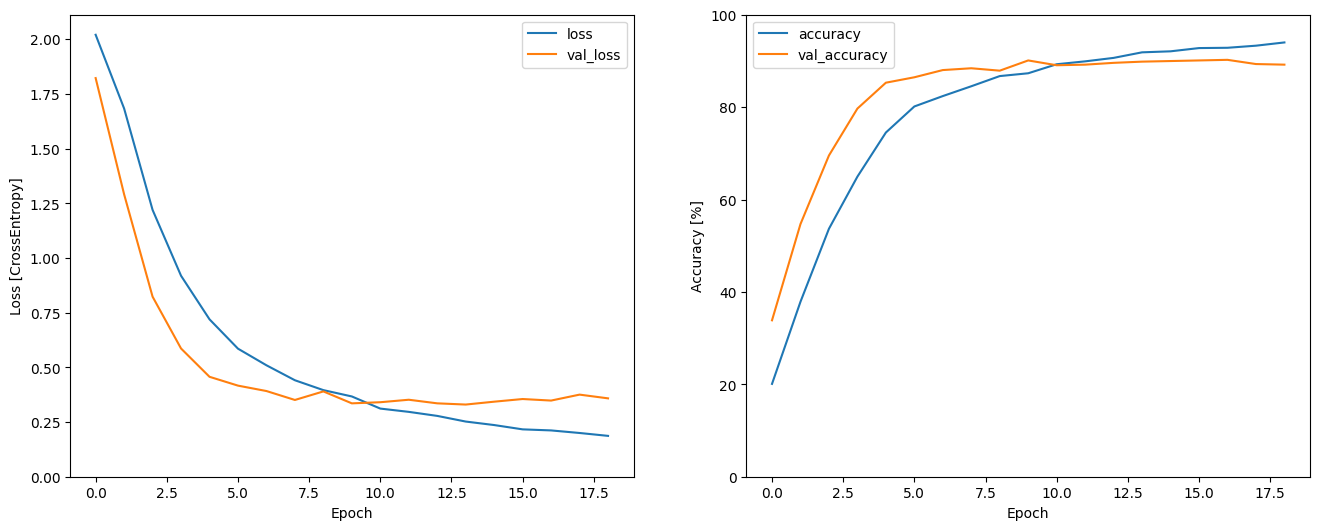

In [37]:
metrics = history.history
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch')
plt.ylabel('Loss [CrossEntropy]')

plt.subplot(1,2,2)
plt.plot(history.epoch, 100*np.array(metrics['accuracy']), 100*np.array(metrics['val_accuracy']))
plt.legend(['accuracy', 'val_accuracy'])
plt.ylim([0, 100])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [38]:
model.evaluate(test_spectrogram_ds, return_dict=True)

 3/13 [=====>........................] - ETA: 0s - loss: 0.5091 - accuracy: 0.8229

13/13 [==============================] - 0s 26ms/step - loss: 0.3751 - accuracy: 0.8738


{'loss': 0.375137060880661, 'accuracy': 0.8737980723381042}

### Display a confusion matrix

Use a [confusion matrix](https://developers.google.com/machine-learning/glossary#confusion-matrix) to check how well the model did classifying each of the commands in the test set:


Make predictions for all the test dataset

In [39]:
y_pred = model.predict(test_spectrogram_ds)

13/13 [==============================] - 1s 26ms/step


Use argmax to get the prediction with highest probabilities

In [40]:
y_pred = tf.argmax(y_pred, axis=1)

In [41]:
y_true = tf.concat(list(test_spectrogram_ds.map(lambda s,lab: lab)), axis=0)

### Plot confusion matrix

A confusion matrix for a classification problem with 8 classes would be represented as an 8x8 matrix. Each row of the matrix corresponds to the instances in a predicted class, and each column corresponds to the instances in an actual class. The elements of the matrix represent the counts of instances falling into each combination of predicted and actual classes.

The diagonal of the matrix shows the right predictions. All the predictions fall to the diagonal of the matrix means the model is perfect.

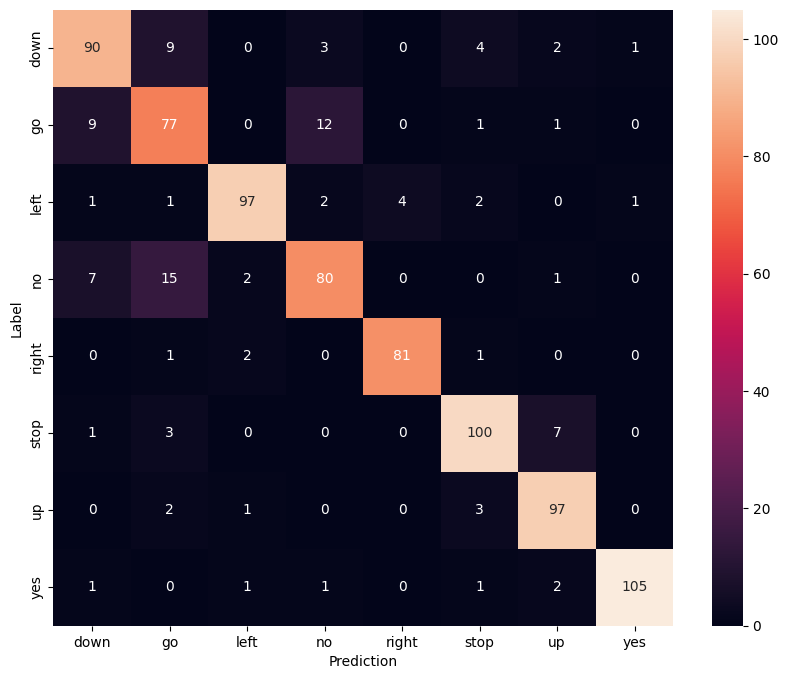

In [42]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

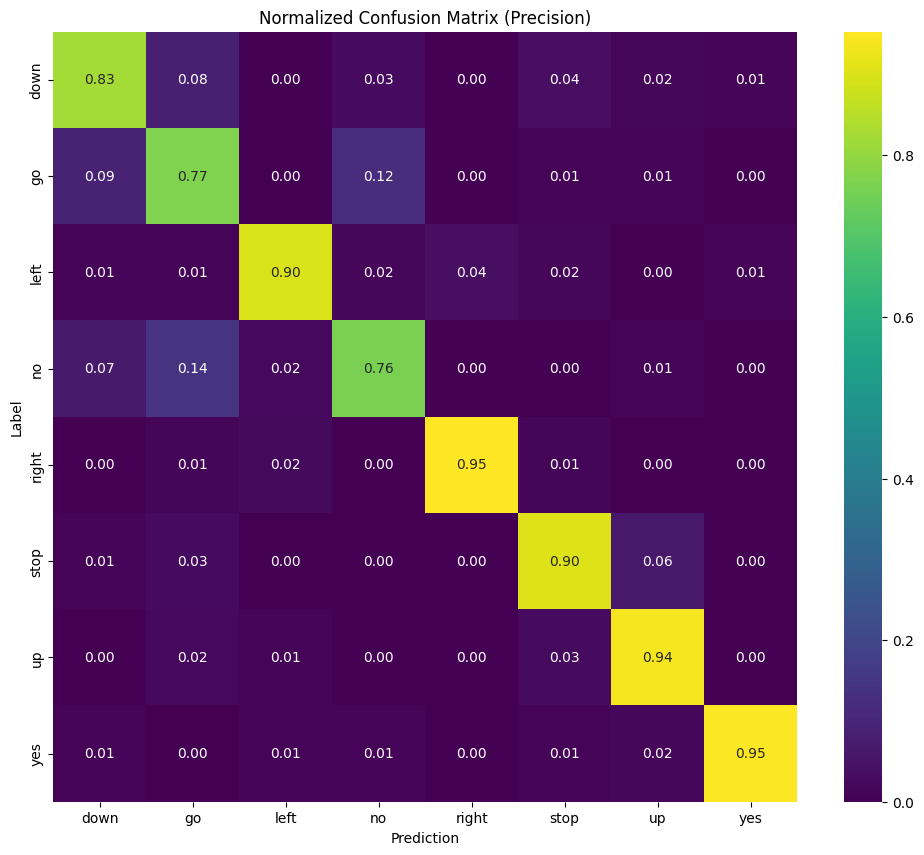

In [43]:

# Compute the confusion matrix
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)

# Normalize each row to have a sum of 1 (precision)
confusion_mtx_normalized = confusion_mtx / tf.reduce_sum(confusion_mtx, axis=1, keepdims=True)

# Plot the normalized confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_mtx_normalized,
            xticklabels=label_names,
            yticklabels=label_names,
            annot=True, fmt='.2f', cmap='viridis')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.title('Normalized Confusion Matrix (Precision)')
plt.show()


## Test the model with other voices 

Let's verify the model's prediction output using an input audio file that recorded after the model training

In [44]:
def make_prediction(x):
    x = tf.io.read_file(x)
    x, sample_rate = tf.audio.decode_wav(x, desired_channels=1, desired_samples=16000,)
    x = tf.squeeze(x, axis=-1)
    waveform = x
    x = get_spectrogram(x)
    x = x[tf.newaxis,...]
    prediction = model(x)
    x_labels = ['down', 'go', 'left', 'no' ,'right', 'stop','up','yes']
    predicted_label_index = tf.argmax(tf.nn.softmax(prediction[0]))
    plt.bar(x_labels, tf.nn.softmax(prediction[0]))
    plt.ylabel("Probability")
    plt.title(f"Prediction of the model: {x_labels[predicted_label_index.numpy()]}")
    plt.xlabel("Labels")
    plt.show()

    display.display(display.Audio(waveform, rate=16000))

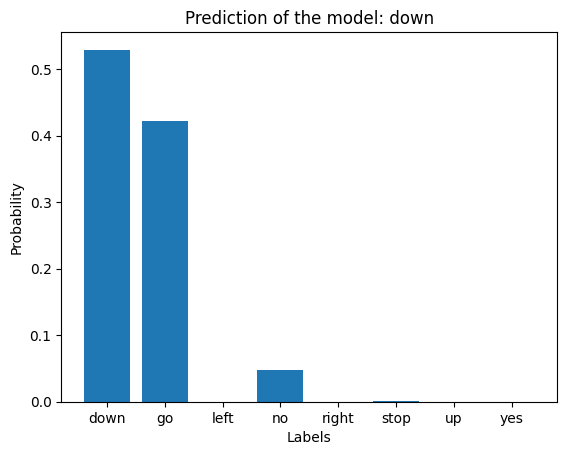

In [46]:
make_prediction("./Verifying_sounds/down_3.wav")

As we hear from the sound file, the prediction should be down, and the model predicted correctly, but the probabilities of "go" and "stop" are still high. Let's make other predictions with label "down". This time the "confidence" is really high

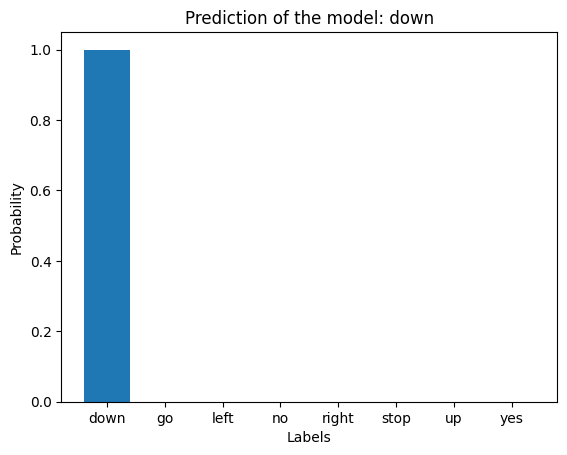

In [47]:
make_prediction("./Verifying_sounds/down_test_2.wav")

Other classes predictions

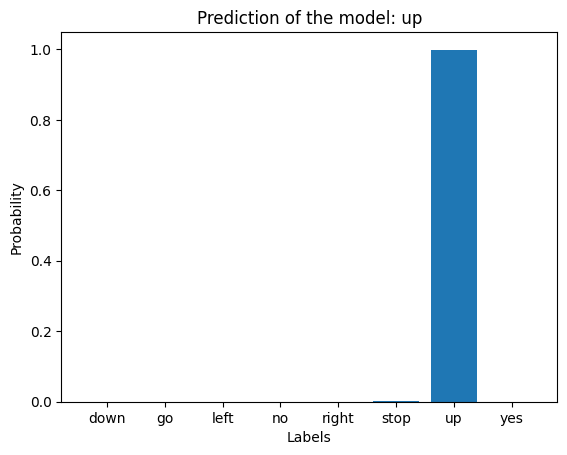

In [48]:
make_prediction("./Verifying_sounds/up_test.wav")

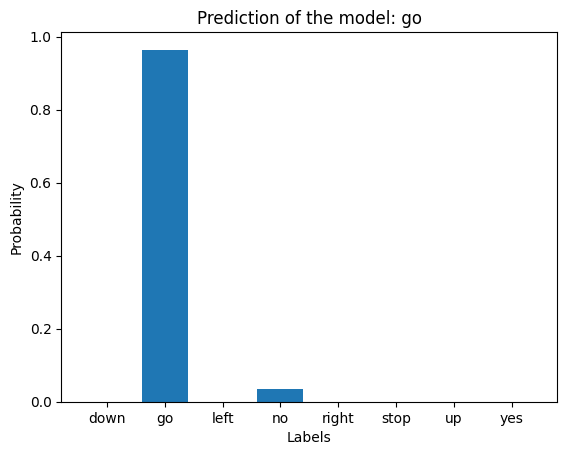

In [50]:
make_prediction("./Verifying_sounds/no.wav")

Hearing two "no" at the same time, the model confused with "go"

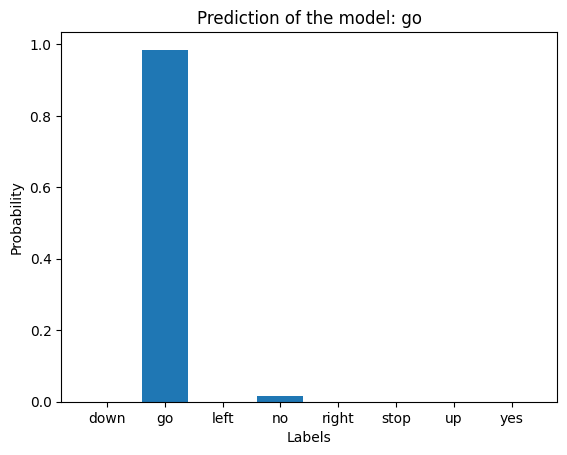

In [51]:
make_prediction("./Verifying_sounds/two_no_sametime.wav")

What about silence with some noise? In this experiment we train no samples with "silence" class

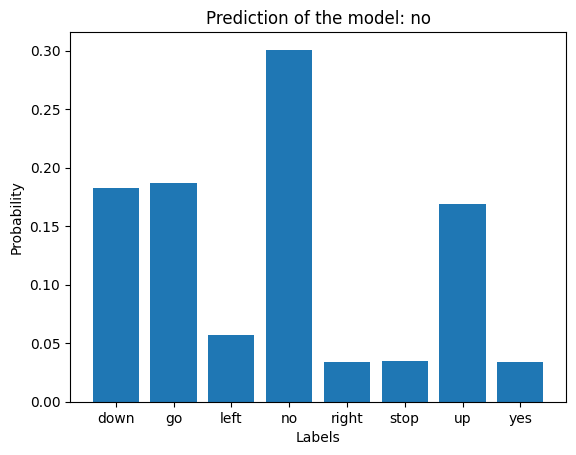

In [53]:
make_prediction("./Verifying_sounds/silence_1.wav")

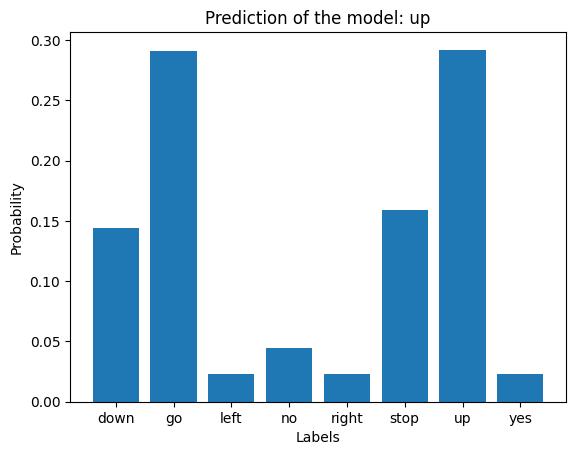

In [54]:
make_prediction("./Verifying_sounds/silence_2.wav")